---
## For Python, we will use yfinance to get the data

In [1]:
import yfinance as yf 
import numpy as np 
import pandas as pd 

As mentioned in the R Markdown, we will try building a portfolio with the following seven stocks, which are identified as high-growth stocks by Forbe, WTOP, and U.S. News. We want monthly data and consistency among R, Python and Excel so we will use the same timestampt. 

In [2]:
tickers=["HWM", "NVDA", "MSI", "AMZN", "MA", "TSLA", "ALB"]
prices = yf.download(tickers, start="2016-11-01", end="2025-09-02",interval="1mo")["Close"]

/var/folders/qm/71bzq9451kqf888zy5kpswfr0000gn/T/ipykernel_32549/878492577.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start="2016-11-01", end="2025-09-02",interval="1mo")["Close"]
[*********************100%***********************]  7 of 7 completed


In [3]:
prices.head(3)

Ticker,ALB,AMZN,HWM,MA,MSI,NVDA,TSLA
Date,,,,,,,
2016-11-01,78.149910,37.5285,14.129128,97.143646,70.244675,2.267476,12.626667
2016-12-01,76.636398,37.4935,13.657713,98.141739,72.555519,2.628988,14.246000
2017-01-01,82.753098,41.1740,16.788523,101.069344,71.051620,2.689085,16.795334


`Prices are noise. Returns are what matter` Let's get the return dataset

In [4]:
returns = prices.pct_change().dropna()

In [5]:
mu=returns.mean() *12 # For now we will just use the average for expected return
covar=returns.cov() *12 # Annualize returns and find the covariance matrix

---
# Monte Carlo

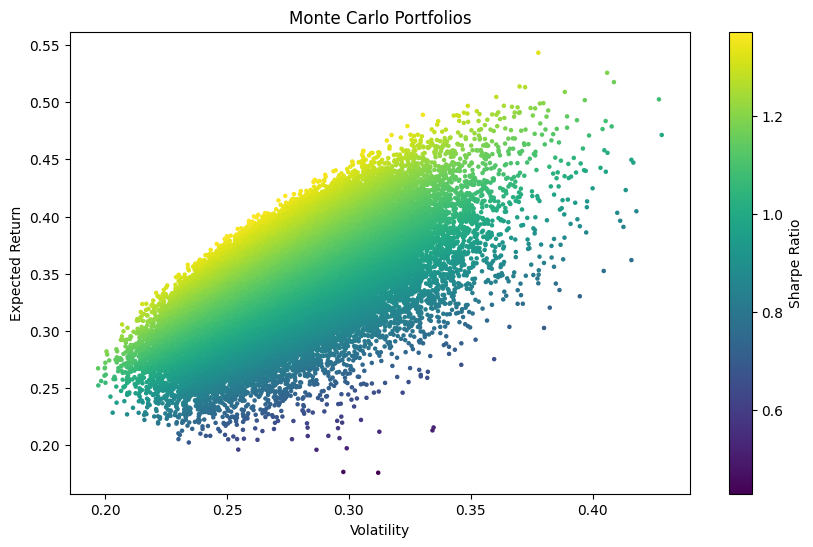

In [6]:
import matplotlib.pyplot as plt

n_assets = len(tickers)
n_portfolios = 50_000
rf = 0.04232                            # annual risk-free rate
Sigma=covar
results = np.zeros((3, n_portfolios))      # rows: ret, vol, Sharpe. Hence 3
weights_record = []

for i in range(n_portfolios):
    w = np.random.random(n_assets)
    w /= w.sum()                           # normalize to 1
    weights_record.append(w)
    
    port_return = np.dot(w, mu)
    port_vol    = np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
    sharpe      = (port_return - rf) / port_vol
    
    results[0,i] = port_return
    results[1,i] = port_vol
    results[2,i] = sharpe

# plot Monte Carlo portfolios
plt.figure(figsize=(10,6))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', s=5)
plt.xlabel("Volatility")
plt.ylabel("Expected Return")
plt.colorbar(label="Sharpe Ratio")
plt.title("Monte Carlo Portfolios")
plt.show()

Let's maximize the Sharpe ratio

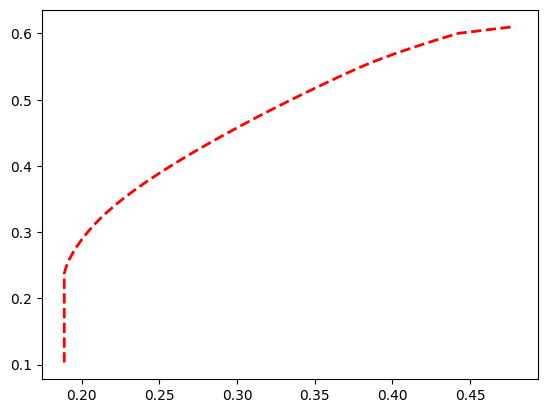

In [7]:
from scipy.optimize import minimize

def portfolio_perf(weights, mu, Sigma, rf=rf):
    ret = np.dot(weights, mu)
    vol = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
    return ret, vol

def min_var(target_return, mu, Sigma):
    n = len(mu)
    init = np.ones(n)/n
    bounds = [(0, 1)] * n
    constraints = (
        {'type':'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type':'ineq', 'fun': lambda w: np.dot(w, mu) - target_return}
    )
    obj = lambda w: np.dot(w.T, np.dot(Sigma, w))   # variance
    result = minimize(obj, init, bounds=bounds, constraints=constraints)
    return result.x

target_returns = np.linspace(mu.min(), mu.max(), 50)
frontier_vols = []

for tr in target_returns:
    w = min_var(tr, mu, Sigma)
    ret, vol = portfolio_perf(w, mu, Sigma)
    frontier_vols.append(vol)

plt.plot(frontier_vols, target_returns, 'r--', linewidth=2, label="Efficient Frontier")

---
# Capital Allocation Line (Maximize Sharpe ratio)


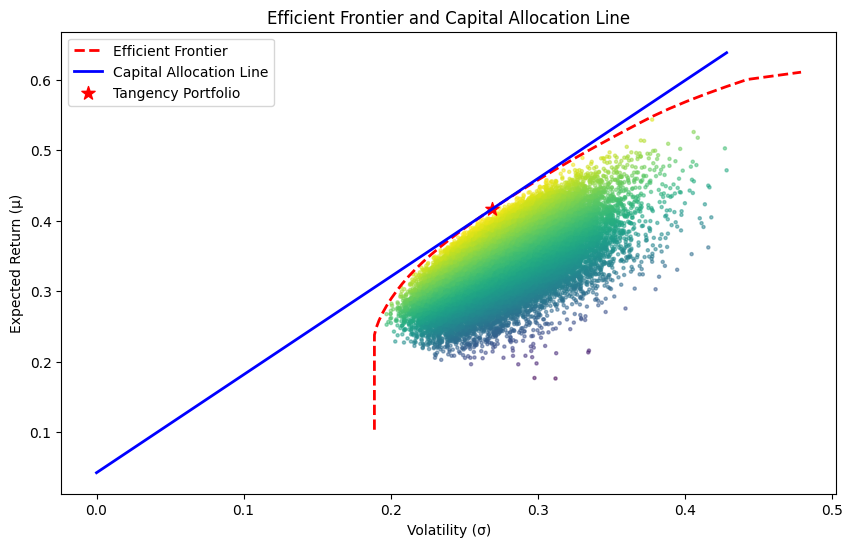

Tangency Portfolio Weights:
{'HWM': 0.0, 'NVDA': 0.0, 'MSI': 0.156, 'AMZN': 0.125, 'MA': 0.289, 'TSLA': 0.338, 'ALB': 0.092}


In [8]:
target_return=0.1
n=len(tickers)
bounds = [(0.0, 1.0)] * n  # no shorting
constraints = [
    {'type': 'eq',   'fun': lambda w: np.sum(w) - 1},                  # budget
    {'type': 'ineq', 'fun': lambda w, mu=mu: np.dot(w, mu) - target_return}  # μᵀw ≥ target
]

def neg_sharpe(w, mu=mu, Sigma=Sigma, rf=rf):
    # SciPy minimizes can only minimize -> to maximize Sharpe -> minimize NEGATIVE Sharpe
    ret = w @ mu
    vol = np.sqrt(w @ Sigma @ w) + 1e-12   # tiny epsilon for stability (numerical safeguard) so sqrt wont break when mmult yeild tiny negative values
    return -(ret - rf) / vol

w0 = np.full(n, 1/n)
opt = minimize(neg_sharpe, w0, bounds=bounds, constraints=constraints, method='SLSQP')
w_tan = opt.x

ret_tan = w_tan @ mu
vol_tan = np.sqrt(w_tan @ Sigma @ w_tan)

# Capital Allocation Line (CAL)
cal_vols = np.linspace(0, max(results[1,:]), 100)
cal_rets = rf + (ret_tan - rf) / vol_tan * cal_vols

# Plot
plt.figure(figsize=(10,6))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', s=5, alpha=0.5)
plt.plot(frontier_vols, target_returns, 'r--', linewidth=2, label="Efficient Frontier")
plt.plot(cal_vols, cal_rets, 'b-', linewidth=2, label="Capital Allocation Line")
plt.scatter(vol_tan, ret_tan, c='red', s=100, marker='*', label="Tangency Portfolio")
plt.xlabel("Volatility (σ)")
plt.ylabel("Expected Return (μ)")
plt.legend()
plt.title("Efficient Frontier and Capital Allocation Line")
plt.show()

print("Tangency Portfolio Weights:")
print(dict(zip(tickers, np.round(w_tan, 3))))

In [16]:
print(f"The sharpe ratio of the optimal portfolio is: {-opt.fun}")

The sharpe ratio of the optimal portfolio is: 1.3910819032098785


In [17]:
mu

Ticker
ALB     0.103295
AMZN    0.249847
HWM     0.374146
MA      0.232299
MSI     0.243505
NVDA    0.610559
TSLA    0.569203
dtype: float64

As we can see, the average growth for these stocks are extremely high because 2016-2025 is the golden period for tech companies and their stocks. This is very likely to not happen again in the future. To stablize and achieve a more realistic numbers, let's use LSTM to predict the monthly return of each assets. 

---
Stock data is very noisy so to predict an exact return is impossible. Instead, we care about the direction of the predictions, which our relative assets model does really well (above 70%). We will put 30% weight on the LSTM prediction and 70% and historical mean.

In [18]:
lstm_pred=[np.float32(-0.023349298),
 np.float32(0.003958315),
 np.float32(0.04078467),
 np.float32(0.015256338),
 np.float32(0.020482888),
 np.float32(0.043185662),
 np.float32(-0.0031317333)]

In [30]:
weighted_lstm=[r*0.3 for r in lstm_pred]

In [33]:
weighted_mu=mu*0.7+weighted_lstm

Let's use this return matrix to maximize our Sharpe Ratio

In [36]:
def neg_sharpe(w, mu=weighted_mu, Sigma=Sigma, rf=rf):
    # SciPy minimizes can only minimize -> to maximize Sharpe -> minimize NEGATIVE Sharpe
    ret = w @ mu
    vol = np.sqrt(w @ Sigma @ w) + 1e-12   # tiny epsilon for stability (numerical safeguard) so sqrt wont break when mmult yeild tiny negative values
    return -(ret - rf) / vol

w0 = np.full(n, 1/n)
opt = minimize(neg_sharpe, w0, bounds=bounds, constraints=constraints, method='SLSQP')
w_tan = opt.x
ret = w_tan @ weighted_mu
vol = np.sqrt(w_tan @ Sigma @ w_tan)

print("Tangency Portfolio Weights:")
print(dict(zip(tickers, np.round(w_tan, 3))))
print(f"Return of this portfolio is: {np.round(ret,4)}")
print(f"Volatility of this portfolio is: {np.round(vol,4)}")
print(f"The sharpe ratio of the optimal portfolio is: {-opt.fun}")

Tangency Portfolio Weights:
{'HWM': 0.0, 'NVDA': 0.0, 'MSI': 0.186, 'AMZN': 0.077, 'MA': 0.277, 'TSLA': 0.37, 'ALB': 0.09}
Return of this portfolio is: 0.3115
Volatility of this portfolio is: 0.2806
The sharpe ratio of the optimal portfolio is: 0.959526160628428


In [3]:
!streamlit run portfolio_performance.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.12.116:8501

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            
2025-09-24 01:10:24.710 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
^C
  Stopping...
